In [1]:
!pip install --user hvplot networkx

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import sys; sys.path.extend(['/home/patrick/.local/bin'])

In [13]:
%matplotlib inline
sys.path.extend(['..'])
import numpy as np
import pandas as pd
import re
import operator
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
# import hvplot.pandas
# import holoviews as hv
# import networkx as nx

from IPython.display import display, HTML
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.decomposition import PCA

from tensorflow_models.data_loaders import load_newsgroups

pd.set_option('display.float_format', '{:.2f}'.format)

## Load

In [3]:
train, valid, test, target_names = load_newsgroups(clean=True, 
                                                   filters=['email', 'digits', 'nonwords'], 
                                                   stopwords=False, 
                                                   rm_header=True, 
                                                   stem=False)

X_train, y_train, m_train = train

Training set loaded in 6.12 s: 9051 training examples, 2263 validation examples
Supervised examples: 9051 out of 9051
Testing set loaded in 3.62 s: 7532 testing examples
Total time: 9.75 s


In [16]:
from tensorflow_models.base import Config
from tensorflow_models.data_loaders import TfIdfGenerator

config = Config('ssae.yaml')
generator = TfIdfGenerator(load_newsgroups, config)
X_train, y_train, _ = generator.train
X_train

../tensorflow_models/base/config.py:43: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  cfg = parse_config(yaml.load(yaml_file))
../tensorflow_models/base/config.py:165: UserWarning: No check for activation
  warnings.warn("No check for {}".format(attr))
../tensorflow_models/base/config.py:165: UserWarning: No check for callback_flags
  warnings.warn("No check for {}".format(attr))
../tensorflow_models/base/config.py:165: UserWarning: No check for callbacks
  warnings.warn("No check for {}".format(attr))
../tensorflow_models/base/config.py:165: UserWarning: No check for classification_loss
  warnings.warn("No check for {}".format(attr))
../tensorflow_models/base/config.py:165: UserWarning: No check for dropout
  warnings.warn("No check for {}".format(attr))
../tensorflow_models/base/config.py:165: UserWarning: No check for encoder_dims
  warnings.warn("No check for {}".fo

Training set loaded in 0.05 s: 9051 training examples, 2263 validation examples
Supervised examples: 200 out of 9051
Testing set loaded in 0.02 s: 7532 testing examples
Total time: 0.06 s
An empty vectorizer was instantiated.
Num features: 17455


array([[1.16276710e-09, 1.16276710e-09, 1.16276710e-09, ...,
        1.16276710e-09, 1.16276710e-09, 1.16276710e-09],
       [1.16276710e-09, 1.16276710e-09, 1.16276710e-09, ...,
        1.16276710e-09, 1.16276710e-09, 1.16276710e-09],
       [3.83139200e-10, 3.83139200e-10, 3.83139200e-10, ...,
        3.83139200e-10, 3.83139200e-10, 3.83139200e-10],
       ...,
       [2.49989091e-09, 2.49989091e-09, 2.49989091e-09, ...,
        2.49989091e-09, 2.49989091e-09, 2.49989091e-09],
       [4.99956366e-09, 4.99956366e-09, 4.99956366e-09, ...,
        4.99956366e-09, 4.99956366e-09, 4.99956366e-09],
       [1.92301237e-09, 1.92301237e-09, 1.92301237e-09, ...,
        1.92301237e-09, 1.92301237e-09, 1.92301237e-09]])

In [17]:
X_train.sum(axis=1)

array([1., 1., 1., ..., 1., 1., 1.])

## Subsets statistics

In [94]:
# df = pd.DataFrame()
# for name, subset in zip(['train', 'validation', 'test'], [train, valid, test]):
#     texts, _, _ = subset
#     counts = pd.Series(CountVectorizer(min_df=5).fit_transform(texts).toarray().sum(axis=1))
#     df[name] = counts.describe()
    
# pd.set_option('display.float_format', '{:,.0f}'.format)
# columns = pd.MultiIndex.from_product([['Raw data', 'Clean data'], ['train', 'validation', 'test']])
# columns = columns.set_levels([['\textbf{' + c + '}' for c in level] for level in columns.levels])
# df = pd.concat([df_raw, df_clean], axis=1)
# df.columns = columns
# df.index = [row.replace('%', '\%') for row in df.index]
# print(df.to_latex(bold_rows=True, column_format='l'+'c'*6, multicolumn_format='c', escape=False))
# pd.set_option('display.float_format', '{:.4f}'.format)

## Zipf Distribution

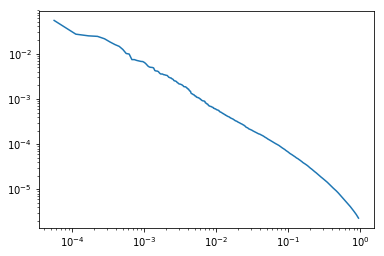

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.preprocessing import MinMaxScaler


def zipf_distribution(collection, relative=False, **vect_options):
    vectorizer = CountVectorizer(**vect_options)
    counts = vectorizer.fit_transform(collection).sum(axis=0).reshape(-1, 1)
    
    freq = counts / counts.sum(axis=0) if relative else counts
    features = pd.Index(vectorizer.get_feature_names(), name='feature')
    counts = (pd.DataFrame(freq, index=features, columns=['count'])
              .sort_values('count', ascending=False)
              .assign(rank=lambda df: df['count'].rank(ascending=False, method='min', pct=relative)))
    return counts, vectorizer.vocabulary_
    

def plot_zipf(counts, tokens, save=False):
    # A Zipf plot
    ranks = np.arange(1, len(counts) + 1)
    indices = np.argsort(-counts)
    frequencies = counts[indices]

    plt.loglog(ranks, frequencies, marker='.')
    # plt.title("Zipf plot for Brown corpus tokens")
    plt.xlabel("Frequency rank of token")
    plt.ylabel("Absolute frequency of token")

    for n in list(np.logspace(-0.5, np.log10(len(counts)), 20).astype(int)):
        _ = plt.text(ranks[n], frequencies[n], " " + tokens[indices[n]],
                     fontdict={'size': 18},
                     verticalalignment="bottom",
                     horizontalalignment="left")

    if save:
        plt.tight_layout()
        plt.savefig(save)
        

total_counts, vocabulary = zipf_distribution(X_train, min_df=5, relative=True)
plt.loglog(total_counts['rank'], total_counts['count']);

In [7]:
# for i, text in enumerate(X_train):
#     if 'maxaxaxaxaxaxaxaxaxaxaxaxaxaxax' in text:
#         print(i, target_names[y_train[i].argmax()])
#         print(text)
#         input()

In [8]:
# thresh = 15
# total_counts[total_counts.index.map(lambda s: len(s) > thresh)]

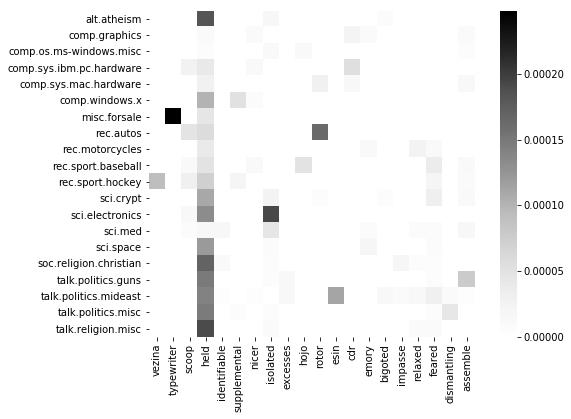

In [14]:
counts_per_class = pd.DataFrame(index=total_counts.index) 
labels = np.argmax(y_train, axis=1)

def formatter(xfix, prefix=True):
    def func(*args):
        args = list(args)
        if prefix:
            args.insert(0, xfix)
        else:
            args.append(xfix)
        return '_'.join(args)
    return func

# top_words = []
for i, label in enumerate(target_names):
    class_dist, _ = zipf_distribution(X_train[labels == i], vocabulary=vocabulary, min_df=5, relative=True)
    fcol = formatter(label)
    class_dist.columns = [fcol(name) for name in class_dist.columns]
    counts_per_class = counts_per_class.join(class_dist)
    counts_per_class[fcol('count')] = counts_per_class[fcol('count')].fillna(0)
    counts_per_class[fcol('rank')] = counts_per_class[fcol('rank')].fillna(class_dist[fcol('rank')].max() + 1)
#     top_words.append((counts_per_class[fcol('rank')] / total_counts['rank']).sort_values().index[0])

counts_per_class.columns = pd.MultiIndex.from_tuples(counts_per_class.columns.str.split('_').map(tuple), 
                                                     names=['label', 'metric'])

counts_per_class = counts_per_class.swaplevel(axis=1).sort_index(axis=1, level=0)
sns.heatmap(counts_per_class.xs('count', axis=1).sample(20).T, cmap='Greys', square=True)
plt.gca().set_xlabel(''); plt.gca().set_ylabel('')
fig = plt.gcf(); fig.set_size_inches(tuple([x * 1.5 for x in fig.get_size_inches()]))

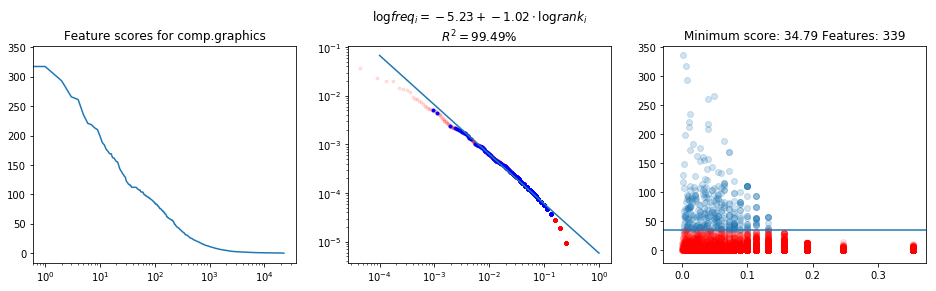

In [125]:
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression

class_id = 1

vect = CountVectorizer(min_df=5)
targets = np.argmax(y_train, axis=1)
targets = targets if class_id is None else (targets == class_id) 

anova = SelectKBest()
anova.fit(vect.fit_transform(X_train), targets)

scores = (pd.DataFrame({'score': anova.scores_, 'pval': anova.pvalues_}, index=vect.get_feature_names())
          .sort_values('score', ascending=False))

thresh = np.quantile(scores['score'], 0.985)
best_scores = scores.where(lambda df: df['score'] >= thresh).dropna()

plt.figure(figsize=(16,4))
plt.subplot(131).plot(np.arange(len(scores)), scores['score'])
plt.xscale('log')
plt.title('Feature scores for {}'.format('all classes' if class_id is None else target_names[class_id]))

mask = counts_per_class.index.isin(best_scores.index)
selected_class = total_counts if class_id is None else counts_per_class.xs(target_names[class_id], level=1, axis=1)
selected_class = selected_class.join(scores['score'])

relevant_words = selected_class.loc[mask]
irrelevant_words = selected_class.loc[~mask]
reg_mask = (relevant_words['count'] != 0)
reg_data = np.log10(relevant_words.loc[reg_mask, ['rank', 'count']]).values
X_reg, y_reg = reg_data[:, :1], reg_data[:, 1]
lr = LinearRegression().fit(X_reg, y_reg)
xx = np.arange(-4, 1, dtype=float)
y_pred = lr.predict(xx.reshape(-1, 1))
plt.subplot(132).loglog(irrelevant_words['rank'], irrelevant_words['count'], 'r.', alpha=0.1);
plt.gca().loglog(relevant_words['rank'], relevant_words['count'], 'b.')
plt.gca().plot(np.power(10, xx), np.power(10, y_pred))
plt.title("$\log freq_i = {:.2f} + {:.2f} \cdot \log rank_i$\n$R^2={:.2%}$%"
          .format(lr.intercept_, lr.coef_[0], lr.score(X_reg, y_reg)))

plt.subplot(133).scatter(relevant_words['rank'], relevant_words['score'], alpha=0.2)
plt.gca().scatter(irrelevant_words['rank'], irrelevant_words['score'], color='r', alpha=0.1)
plt.gca().axhline(thresh)
# plt.xscale('log')
plt.title('Minimum score: {:.2f} Features: {:d}'.format(thresh, len(best_scores)));

In [243]:
ar = ["Hello World This is John, World is nice, nice cat, fair world"]

cvect = CountVectorizer().fit(ar)
cnts = cvect.transform(ar).toarray()
tvect = TfidfVectorizer(use_idf=False, norm='l1').fit(ar)
freq = tvect.transform(ar).toarray()
freq

array([[0.08333333, 0.08333333, 0.08333333, 0.16666667, 0.08333333,
        0.16666667, 0.08333333, 0.25      ]])

In [230]:
total_counts.sort_values('rank').iloc[60:120]

count      rank
feature                    
up       0.001981  0.003415
other    0.001934  0.003471
max      0.001873  0.003527
know     0.001859  0.003583
only     0.001853  0.003639
get      0.001850  0.003695
how      0.001849  0.003751
them     0.001809  0.003807
than     0.001759  0.003863
had      0.001749  0.003919
been     0.001681  0.003975
his      0.001660  0.004031
think    0.001659  0.004087
also     0.001614  0.004143
use      0.001540  0.004199
does     0.001515  0.004255
then     0.001488  0.004311
time     0.001482  0.004367
these    0.001381  0.004423
new      0.001321  0.004479
good     0.001312  0.004535
should   0.001309  0.004591
could    0.001286  0.004647
well     0.001266  0.004703
am       0.001248  0.004759
because  0.001240  0.004815
even     0.001238  0.004871
very     0.001215  0.004927
now      0.001176  0.004983
may      0.001174  0.005039
why      0.001159  0.005095
into     0.001155  0.005151
see      0.001137  0.005207
way      0.001100  0.005263
two      0.001097  0.005319
first    0.001094  0.005375
much     0.001076  0.005431
us       0.001071  0.005487
most     0.001070  0.005543
make     0.001069  0.005599
many     0.001063  0.005655
those    0.001043  0.005711
such     0.001039  0.005767
god      0.001024  0.005823
system   0.001017  0.005879
right    0.001008  0.005935
here     0.000981  0.005991
say      0.000980  0.006047
where    0.000975  0.006103
ve       0.000951  0.006159
want     0.000944  0.006215
re       0.000931  0.006271
our      0.000925  0.006327
anyone   0.000913  0.006383
used     0.000911  0.006439
same     0.000905  0.006495
over     0.000905  0.006495
go       0.000904  0.006607
did      0.000898  0.006663
being    0.000896  0.006719

'atheism'

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


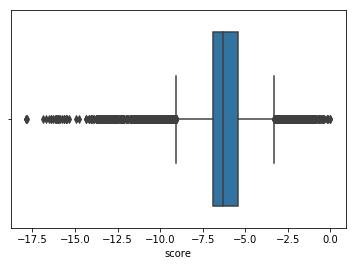

In [56]:
def softmax(x):
    return np.exp(x) / np.exp(x).sum()

def sigmoid(x):
    return (1 + np.exp(-x)) ** (-1)

def tanh(x):
    return 2 / (1 + np.exp(-2*x)) - 1

def minmax_scale(x):
    return (x - x.min()) / (x.max() - x.min())

# plt.loglog(np.arange(len(scores)), softmax(scores['score']), '.')
# plt.loglog(scores['score'], scores['pval'], '.')
sns.boxplot(np.log(minmax_scale(scores['score'])))

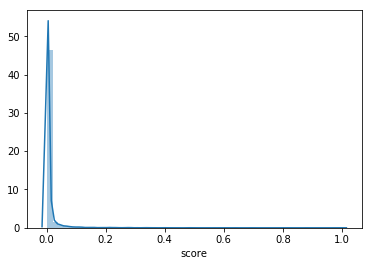

In [70]:
sns.distplot(minmax_scale(scores['score']))

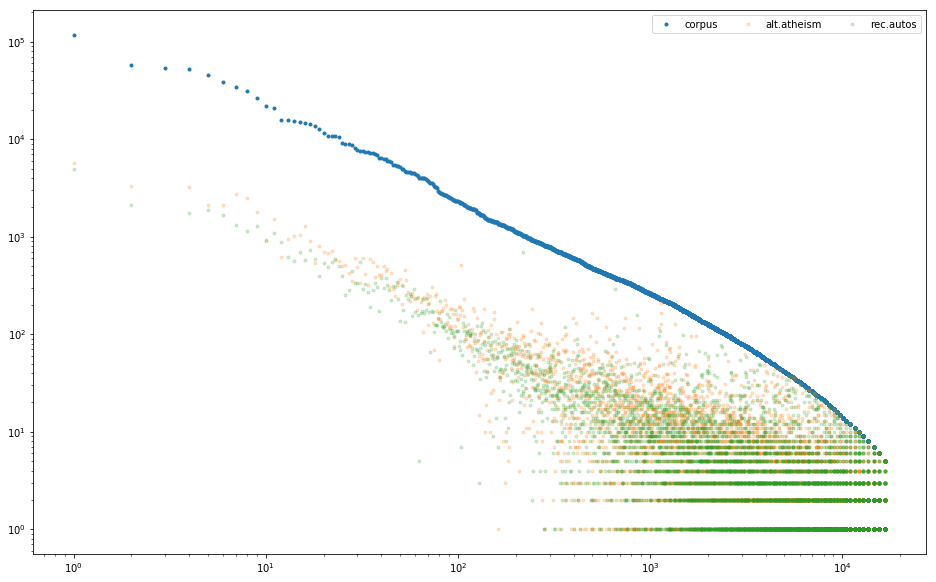

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(16,10))

ax.loglog(total_counts['rank'], total_counts['count'], '.', label='corpus')
selected_labels = ['alt.atheism', 'rec.autos'] #, 'sci.space', 'rec.sport.hockey']
selected_labels = selected_labels or target_names
for label in selected_labels:
    ax.loglog(total_counts['rank'], counts_per_class[('count', label)], '.', label=label, alpha=0.2)
    
ax.legend(ncol=4, loc=1);

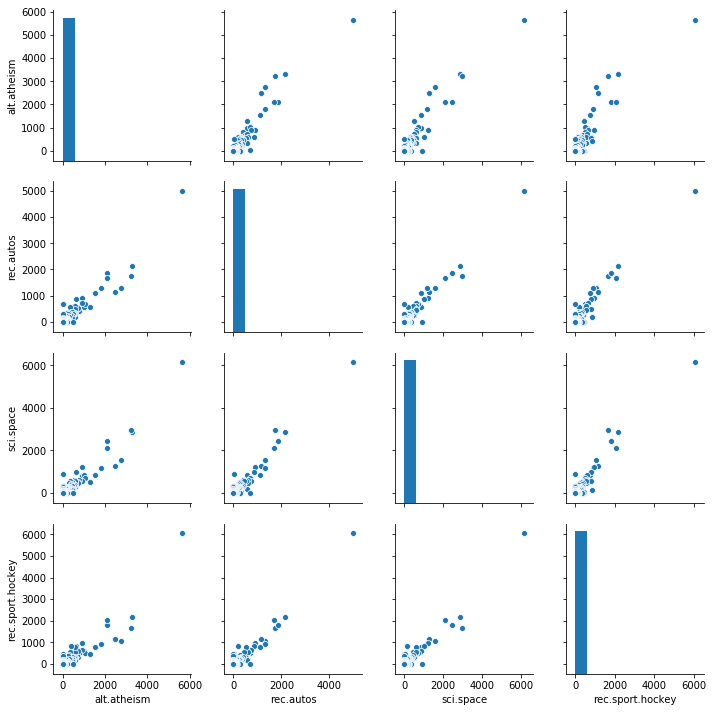

In [25]:
sns.pairplot(counts_per_class.xs('count', level=0, axis=1)[['alt.atheism', 'rec.autos', 'sci.space', 'rec.sport.hockey']])

In [82]:
# fig = plt.figure(figsize=(8,8))

ranks = counts[['rank']].rename(columns={'rank': 'corpus'})
for ystar in range(y_train.shape[1]):
    class_rank, _ = zipf_distribution(X_train[labels == ystar], vocabulary=vocabulary)
    label = target_names[ystar]
    ranks = ranks.join(class_rank.rename(columns={'rank': label}).drop('count', axis=1))
    ranks[label] = ranks[label].fillna(ranks[label].max() + 1)
#     plt.loglog(cnts.index, cnts['count'], label=target_names[ystar])

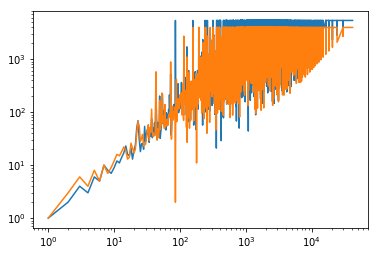

In [85]:
for label in ranks.iloc[:, [2,3]]:
    plt.loglog(ranks['corpus'], ranks[label], label=label)

## Text cleaning

In [3]:
# from tensorflow_models.data_loaders.newsgroups import clean_texts

# X_train = pd.Series(X_train)
# clean_texts(X_train, stopwords=False, filters=['email', 'digits', 'nonwords'], rm_header=True, stem=False)

In [4]:
def remove_header(text):
    text = text.strip()
    n_lines = 'Lines\: \d+\n'
    org = 'Organization\: .*?\n'
    replyto = 'Reply-To\: .*?\n'
    xnews = 'X-Newsreader: .*?\n'
    nntp = 'NNTP-Posting-Host\: .*?\n'
    news_soft = 'News-Software\: .*?\n'
    patterns = [n_lines, org, replyto, xnews, nntp]
    flag = False
    for pattern in patterns:
        match = re.search(pattern, text, re.IGNORECASE)
        if match:
            text = text[match.span()[1]:].strip()
            flag = True
    return text
    
# X_clean = np.array(list(map(remove_header, X_train)))

## Word / document distribution

In [4]:
vect = TfidfVectorizer(min_df=10, max_df=0.8, stop_words='english')
X_vect =  vect.fit_transform(X_train).toarray()
vocabulary = vect.vocabulary_
word_index = list(map(operator.itemgetter(0), sorted(vocabulary.items(), key=operator.itemgetter(1))))
default_stopwords = vect.get_stop_words() or set()
stopwords = vect.stop_words_ | default_stopwords
print("Vocabulary: {} words".format(len(word_index)))

Vocabulary: 10269 words


In [17]:
def show_example(texts, scores, index=None, nrows=20):
    idx = np.random.randint(len(scores))
    text, scores = texts[idx], scores[idx]
    
    series = pd.Series(scores, index=index)
    series = series[series > 0].sort_values(ascending=False).head(20)
    
    rgx = '({})'.format('|'.join(list(map(r'\b{}\b'.format, series.index))))
    text = re.sub(rgx, r'<font color="red">\1</font>', text, flags=re.IGNORECASE)
    
#     display(HTML(r"<p>{}</p>".format(raw.replace('\n', r'<br/>'))))
    display(HTML(r"<p>{}</p>".format(text.replace('\n', r'<br/>'))))
    display(series)

# print(X_vect[np.random.randint(len(X_vect))])
show_example(X_train, X_vect, index=word_index)

se               0.344468
soldering        0.298368
jon              0.199689
speed            0.166794
experience       0.164740
macworld         0.149184
ncaa             0.147501
big              0.145314
wrench           0.143185
specially        0.140764
accelerators     0.139659
carr             0.139659
bw               0.138613
grayscale        0.138613
lone             0.136677
compatibility    0.134094
netland          0.133304
bears            0.131816
plugs            0.127934
champions        0.126796
dtype: float64

In [6]:
def filter_stopwords(documents, stopwords):
    
    def is_not_stopword(word):
        return word not in stopwords
    
    documents = documents.copy()
    for i in range(len(documents)):
        doc_as_list = documents[i].split()
        documents[i] = ' '.join(list(filter(is_not_stopword, doc_as_list)))
    return documents

X_clean = filter_stopwords(X_train, stopwords)
show_example(X_clean, X_vect, word_index)

brian            0.377577
offer            0.349506
economics        0.274484
olson            0.256854
campus           0.238770
cash             0.232410
won              0.208186
studies          0.206630
shipping         0.199659
ibm              0.198900
putting          0.198650
international    0.193302
plus             0.182364
sale             0.180124
nice             0.162394
local            0.161707
david            0.144536
computer         0.144411
best             0.134626
university       0.132344
dtype: float64

In [7]:
def make_cooccurence_matrix(documents, vocabulary):
    cooccurence_matrix = np.zeros(shape=(len(vocabulary), len(vocabulary)))
    for doc in documents:
        words = doc.split()
        for i in range(len(words)):
            try:
                wordindex1 = vocabulary[words[i]]
            except KeyError:
                continue
            for j in range(i, len(words)):
                try: 
                    wordindex2 = vocabulary[words[j]]
                except KeyError:
                    continue
                cooccurence_matrix[wordindex1, wordindex2] += 1
    return cooccurence_matrix
           
t0 = time()
cooccurrences = make_cooccurence_matrix(X_clean, vocabulary)
print("Took {:.2f}s".format(time() - t0))

Took 180.32s


In [8]:
pd.Series(cooccurrences.sum(axis=1), index=word_index).sort_values(ascending=False).head(20)

file           1495919.0
people         1183042.0
use            1071608.0
dont            823465.0
available       799524.0
like            796723.0
information     744285.0
article         742093.0
new             741037.0
know            720403.0
just            720103.0
data            695257.0
time            690196.0
writes          681870.0
program         658635.0
does            641709.0
think           586715.0
said            568372.0
used            549986.0
image           537967.0
dtype: float64

In [10]:
# df = pd.DataFrame(cooccurrences, index=word_index, columns=word_index)
# mask = df.sum(axis=0) > 5700
# df.loc[mask, mask]

In [9]:
pd.Series(cooccurrences[:, vocabulary['turkish']], index=word_index).sort_values(ascending=False).head(20)

turkish      7435.0
jews         4925.0
turkey       3602.0
armenian     2091.0
people       1899.0
armenians    1722.0
ottoman      1666.0
nazis        1543.0
war          1490.0
turks        1299.0
book         1244.0
jewish       1182.0
world        1066.0
did           946.0
said          929.0
history       916.0
came          892.0
greek         877.0
new           872.0
years         867.0
dtype: float64

In [15]:
def plot_eigenvalues(eigenvalues, thresh=0.8, k_star=None):
    
    eigenvalues = np.concatenate([[0], eigenvalues.cumsum()])
    if k_star:
        xstar = k_star
    else:
        xstar = (eigenvalues > thresh).argmax()
    ystar = eigenvalues[xstar]
        
    red, blue, grey = "#990000", "#2d5986", '#8c8c8c'
  
    vline = hv.VLine(xstar).options(color=red, line_width=1.)
    hline = hv.HLine(ystar).options(color=red, line_width=1.)
    overlay = (pd.Series(eigenvalues, name='%var').hvplot(color=blue)
               * vline * hline
               * hv.Text(xstar + (.15 * len(eigenvalues)), ystar - 0.4, 
                         f"""{xstar} components explain\n{ystar:.1%} of the variance""", 
                         halign='center'))
    
    return overlay

# pca = PCA(n_components=1000)
# pca.fit(cooccurrences)

plot_eigenvalues(pca.explained_variance_ratio_, thresh=0.95, k_star=20)

:Overlay
   .Curve.Percent_var :Curve   [index]   (%var)
   .VLine.I           :VLine   [x,y]
   .HLine.I           :HLine   [x,y]
   .Text.I            :Text   [x,y]

In [16]:
def get_word_composition(components, word_index, top=True, bottom=True, k=10):
    n_components = len(components)
    indexslice = pd.IndexSlice[np.r_[0:k,-k:0]]
    df = pd.DataFrame(index=indexslice)
    for i in range(n_components):
        series = (pd.Series(components[i, :], index=word_index)
                  .sort_values()
                  .iloc[indexslice]
                  .index)
        df[i] = series
    return df

pca20 = PCA(n_components=20)
pca20.fit(cooccurrences)
components = pca20.components_

get_word_composition(components, word_index)

0            1          2          3            4   \
 0                  xxxdate         file     people  available    anonymous   
 1             xxxmessageid          use       said      image     internet   
 2                  nuntius       people       dont       data  information   
 3                    vnews    available       know   software      privacy   
 4               xuseragent  information       just    version        email   
 5                  wibbled      program      think        use          new   
 6   iftccutalkpoliticsguns         dont      didnt     window         mail   
 7                     parr        image       like       jpeg     computer   
 8                  bissell         like        say    display   electronic   
 9              herringshaw         jpeg        did     server   encryption   
-10                  people       offset  available      didnt          bit   
-9                     data         loop       char       char      quality   
-8                      use    assembled      entry   firearms         dont   
-7                      pop           al      files       know         free   
-6                       si         bits    program     output        color   
-5                     push          pop      image    control       images   
-4                     bits           si        gun     people       format   
-3                     byte         push       jpeg       said          gif   
-2                     file         byte     output        gun        image   
-1                       db           db       file       file         jpeg   

              5            6            7               8               9   \
 0          jpeg         disk          gun            said           space   
 1     anonymous     internet       window           didnt            said   
 2         image         scsi    available       anonymous         program   
 3      internet       drives       widget          people           didnt   
 4       privacy         jpeg         file        internet              ms   
 5           gif          gun      control            went          launch   
 6   information         hard  application       apartment           myers   
 7         email      privacy      subject            file  administration   
 8          mail        drive        motif       armenians       president   
 9        format          rom      version            came            went   
-10         card      contest      privacy          launch            true   
-9            mb      subject       stream           myers           bible   
-8    controller  application        email      government             use   
-7          bios          set      section              ms         believe   
-6           rom         char     internet           think          writes   
-5          hard        entry    anonymous             new            good   
-4         drive       output      contest         program        atheists   
-3        drives      program         char           space            does   
-2          scsi       widget        entry       president           jesus   
-1          disk       window       output  administration             god   

                 10          11          12           13         14  \
 0          turkish        disk     turkish        space      south   
 1            space      drives        jpeg       launch     secret   
 2             jews        bios        jews    satellite        war   
 3              war         rom      window         jpeg    nuclear   
 4            south     feature         war          use    georgia   
 5           launch  controller  government  application      ships   
 6              new     systems         use       market     island   
 7            jesus      floppy      secret   commercial      naval   
 8             time        hard      turkey         dont   military   
 9           sec

/usr/local/lib/python3.5/dist-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


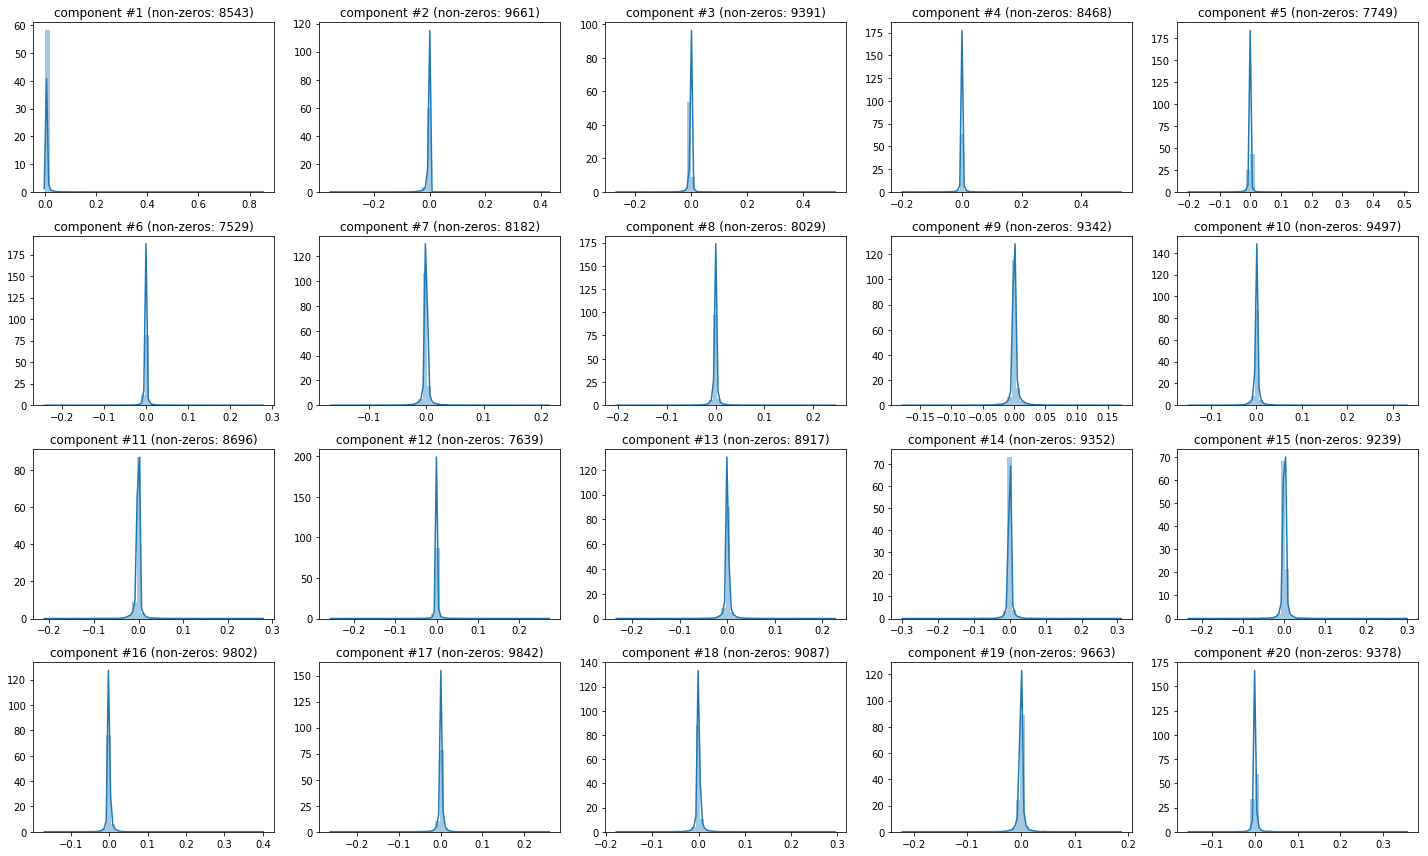

In [15]:
fig, axs = plt.subplots(4, 5, figsize=(20,12))
for c in range(pca20.n_components_):
    ax = axs[c // 5, c % 5]
    sns.distplot(components[c, :], ax=ax)
    non_zeros = (np.abs(components[c, :]) > 1e-4).sum()
    ax.set_title('component #{} (non-zeros: {})'.format(c + 1, non_zeros))
plt.tight_layout()

In [16]:
from keras.preprocessing.sequence import pad_sequences

X_enc = [[vocabulary[w] for w in doc.split() if len(w) > 1] for doc in X_clean]
maxlen = max(map(len, X_enc))
X_pad = pad_sequences(X_enc, maxlen=maxlen)
X_pad.shape

(9051, 3876)

In [17]:
from keras.layers import Conv1D, Embedding, Dense, Input, Flatten, MaxPool1D
from keras.models import Model, Sequential
import keras.backend as K

def build_network(maxlen, embedding_dim, vocab_size, n_classes, embedding_weights):
    X = Input(shape=(maxlen,))
    emb_layer = Embedding(vocab_size,
                          embedding_dim,
                          weights=[embedding_weights],
                          input_length=maxlen,
                          trainable=True)
    pool_layer = MaxPool1D(5, padding='same')
#     conv_layer = Conv1D(32, maxlen)
    flatten_layer = Flatten()
    classifier = Sequential([
        Dense(k, activation='relu' if k != n_classes else 'softmax') 
        for k in (1024, 256, 64, n_classes)])
    
    Xv = emb_layer(X)
#     Xc = conv_layer(Xv)
    Xp = pool_layer(Xv)
    Xf = flatten_layer(Xp)
    y = classifier(Xf)
    
    return Model(inputs=X, outputs=y)

K.clear_session()
net = build_network(maxlen, 20, len(vocabulary), 20, components.T)
net.summary()
net.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3876)              0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 3876, 20)          205380    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 776, 20)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 15520)             0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 20)                16173652  
Total params: 16,379,032
Trainable params: 16,379,032
Non-trainable params: 0
_________________________________________________________________


In [18]:
history = net.fit(X_pad, y_train, validation_split=0.2, batch_size=32, epochs=20)

Instructions for updating:
Use tf.cast instead.
Train on 7240 samples, validate on 1811 samples
Epoch 1/20
7240/7240 [==============================] - 15s 2ms/step - loss: 2.5431 - acc: 0.1575 - val_loss: 1.9172 - val_acc: 0.3092
Epoch 2/20
7240/7240 [==============================] - 11s 2ms/step - loss: 1.4392 - acc: 0.4838 - val_loss: 1.4014 - val_acc: 0.5373
Epoch 3/20
7240/7240 [==============================] - 12s 2ms/step - loss: 0.7976 - acc: 0.7221 - val_loss: 1.2686 - val_acc: 0.6184
Epoch 4/20
7240/7240 [==============================] - 12s 2ms/step - loss: 0.4078 - acc: 0.8739 - val_loss: 1.4811 - val_acc: 0.6367
Epoch 5/20
7240/7240 [==============================] - 13s 2ms/step - loss: 0.2329 - acc: 0.9360 - val_loss: 1.4754 - val_acc: 0.6819
Epoch 6/20
7240/7240 [==============================] - 15s 2ms/step - loss: 0.1404 - acc: 0.9637 - val_loss: 2.0856 - val_acc: 0.6488
Epoch 7/20
7240/7240 [==============================] - 16s 2ms/step - loss: 0.1004 - acc: 0.9

              precision    recall  f1-score   support

           0       0.52      0.44      0.48       319
           1       0.46      0.49      0.48       389
           2       0.64      0.46      0.54       394
           3       0.48      0.67      0.56       392
           4       0.58      0.49      0.53       385
           5       0.48      0.65      0.55       395
           6       0.67      0.58      0.62       390
           7       0.74      0.41      0.53       396
           8       0.65      0.85      0.74       398
           9       0.72      0.68      0.70       397
          10       0.84      0.80      0.82       399
          11       0.80      0.77      0.78       396
          12       0.33      0.48      0.39       393
          13       0.75      0.55      0.63       396
          14       0.68      0.63      0.65       394
          15       0.63      0.61      0.62       398
          16       0.55      0.60      0.58       364
          17       0.90    

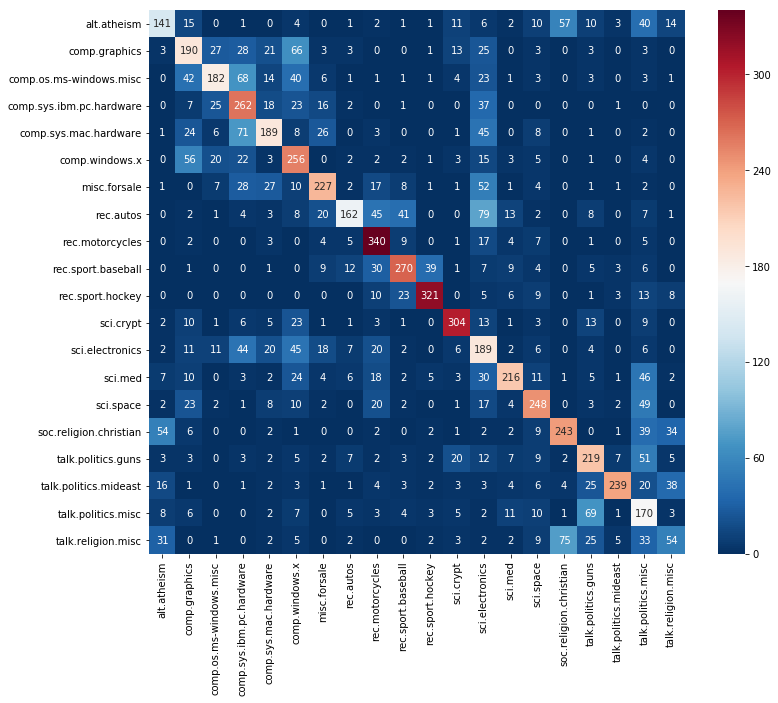

In [19]:
from sklearn.metrics import classification_report, confusion_matrix

X_test, y_test, _ = test
X_clean_te = filter_stopwords(X_test, stopwords)
X_enc_te = [[vocabulary[w] for w in doc.split() if w in vocabulary] for doc in X_clean_te]
X_pad_te = pad_sequences(X_enc_te, maxlen=maxlen)

y_pred = net.predict(X_pad_te)
hard_pred = y_pred.argmax(1)
labels = y_test.argmax(1)

print(classification_report(labels, hard_pred))

fig = plt.figure(figsize=(12, 10))
sns.heatmap(
    confusion_matrix(labels, hard_pred), 
    xticklabels=target_names, 
    yticklabels=target_names, 
    cmap='RdBu_r', 
    annot=True, 
    fmt='d')

In [79]:
G = nx.Graph()
# G.add_nodes_from(list(map('C{}'.format, range(1, pca20.n_components_ + 1))))
# G.add_nodes_from(word_index)

for i, c in enumerate(range(1, pca20.n_components_ + 1)):
    for j, w in enumerate(word_index):
        weight = components[i, j]
        if weight > 1e-2:
            G.add_edge('C{}'.format(c), w, weight=weight)
            
G.number_of_edges(), G.number_of_nodes()

(6003, 2147)

In [80]:
nx.write_gexf(G, 'enron.gexf')

In [85]:
%%javascript

gexf_js_config(dir, graphFile = "enron.gexf", showEdges = TRUE,
  useLens = FALSE, zoomLevel = 0, curvedEdges = TRUE,
  edgeWidthFactor = 1, minEdgeWidth = 1, maxEdgeWidth = 2,
  textDisplayThreshold = 9, nodeSizeFactor = 1, replaceUrls = TRUE,
  showEdgeWeight = TRUE, showEdgeLabel = TRUE, sortNodeAttributes = TRUE,
  showId = TRUE, showEdgeArrow = TRUE, language = FALSE)

// S3 method for class 'gexf'
plot(x, y = NULL, graphFile = "enron.gexf",
  dir = tempdir(), overwrite = TRUE, httd.args = list(),
  copy.only = FALSE)

// Not run: 

path <- system.file("enron.gexf", package="rgexf")
graph <- read.gexf(path)
plot(graph)


// End(Not run)

<IPython.core.display.Javascript object>

<img src='enron.gexf'>